In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import gzip

In [ ]:
# Download data

In [2]:
download_data?


In [6]:
url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz'
path = download_data(url = url, ext = '')
path

PosixPath('/Users/patrickaigner/.fastai/data/train-images-idx3-ubyte.gz')

In [22]:
url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz'
path = download_data(url = url, ext = '')
path

PosixPath('/Users/patrickaigner/.fastai/data/train-labels-idx1-ubyte.gz')

In [23]:
url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz'
path = download_data(url = url, ext = '')
path

PosixPath('/Users/patrickaigner/.fastai/data/t10k-images-idx3-ubyte.gz')

In [24]:
url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz'
path = download_data(url = url, ext = '')
path

PosixPath('/Users/patrickaigner/.fastai/data/t10k-labels-idx1-ubyte.gz')

In [3]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [4]:
path = '/Users/patrickaigner/.fastai/data/'
images, labels = load_mnist(path)

In [5]:
test = images.reshape((60000,1,28,28))

In [65]:
test.shape

(60000, 1, 28, 28)

In [35]:
labels.shape

(60000,)

In [ ]:
# Read data into dataloader

In [6]:
class ArrayImageList(ImageList):
    @classmethod
    def from_numpy(cls, numpy_array):
        return cls(items=numpy_array)
    
    def label_from_array(self, array, label_cls=None, **kwargs):
        return self._label_from_list(array,label_cls=label_cls,**kwargs)
    
    def get(self, i):
        n = self.items[i]
        n = torch.tensor(n).float()
        return Image(n)

In [21]:
bs = 64
tfms = get_transforms(do_flip=False)
defaults.cmap='binary'
classes = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal',
           'shirt', 'sneaker', 'bag', 'ankle_boots']

data = (ArrayImageList.from_numpy(test) 
        .split_by_rand_pct(0.2)             
        .label_from_array(labels)
        .databunch(bs=bs)
        .normalize()) 

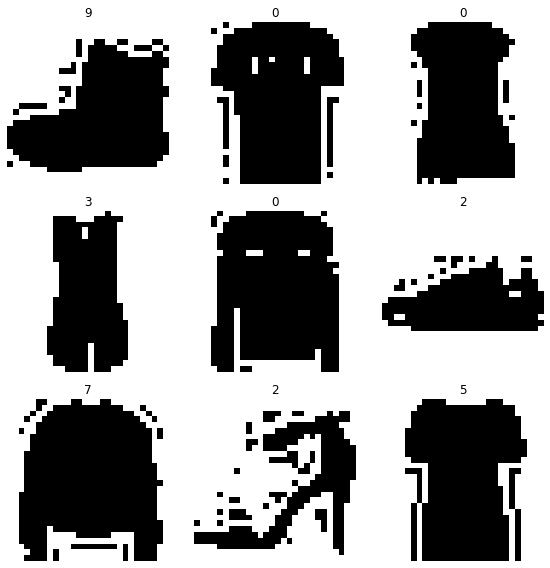

In [8]:
data.show_batch(3, 3, figsize=(8,8))

In [9]:
data.classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
# Create Model

In [10]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [11]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [ ]:
# Create Learner

In [12]:
learn = Learner(data, model=model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
# Train

In [99]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [13]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


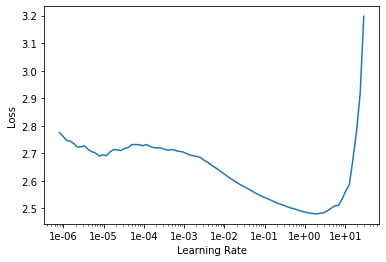

In [14]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(4, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,2.358002,2.320400,0.093500,00:09
1,2.367201,2.389412,0.099583,00:11


RuntimeError: DataLoader worker (pid 10594) is killed by signal: Unknown signal: 0. 

In [18]:
learn.unfreeze()